<a href="https://colab.research.google.com/github/jackkyboy/AAPL-AMZN-GOOG-Price2018-2020/blob/main/Questions_%26_Hypotheses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Block 4 – Research Questions & Hypotheses (New Study)

## Research Question Set B: Dynamic Export Structure (2014–2023)

**RQ1 – Cluster Persistence**  
โครงสร้างการส่งออกของประเทศใน ASEAN-5 + KOR มีรูปแบบคลัสเตอร์ที่ "คงตัว" ตลอดช่วงปี 2014–2023 หรือไม่?  
- ไทยถูกจัดอยู่ในคลัสเตอร์แบบ Hybrid / Consumer-Mixed อย่างต่อเนื่องหรือมีการขยับเข้าใกล้กลุ่ม INT-driven?

**RQ2 – Thailand’s Trajectory**  
ตำแหน่งของไทยบนระนาบ PCA (PC1–PC2) เปลี่ยนไปอย่างไรตลอดปี 2014–2023?  
- ไทยกำลัง "ขยับขึ้น" หรือ "ถอยลง" บนแกนที่สะท้อนความลึกของโครงสร้างอุตสาหกรรมและความหลากหลายของการส่งออก?

**RQ3 – Shock & Volatility**  
ช่วงปีที่มี shock ใหญ่ (เช่น 2020–2021) ทำให้ตำแหน่งของประเทศใน PCA space เปลี่ยนแปลงมากกว่าช่วงอื่นหรือไม่?  
- PCA dispersion (variance ของ PC1/PC2 ระหว่างประเทศ) เพิ่มขึ้นหรือลดลงในช่วง shock?

**RQ4 – Cluster-Based Upgrading Hypothesis**  
ประเทศที่ "ขยับคลัสเตอร์" จากกลุ่ม Consumer/Mixed ไปสู่กลุ่ม INT-driven ระหว่างปี 2014–2023  
มีลักษณะร่วมบางอย่าง เช่น การเพิ่มขึ้นของสัดส่วนสินค้ากลุ่มเทคโนโลยี (XPC, XPHONE, XCARS, XMEDIC, XOIL) หรือไม่?

---

## Hypotheses (H1–H4)

**H1 (Cluster Persistence Hypothesis)**  
คลัสเตอร์โครงสร้างการส่งออกของประเทศส่วนใหญ่ "คงตัว" (cluster membership ไม่เปลี่ยน) ตลอดปี 2014–2023  
แต่ไทยมีความเป็นไปได้สูงที่จะ "ติดอยู่" ในคลัสเตอร์ Hybrid / Consumer-Mixed

**H2 (Thailand Upgrading Hypothesis)**  
ค่าคะแนน PC1 ของไทย (ซึ่งสะท้อน industrial depth หรือ INT / tech share) มีทิศทางเพิ่มขึ้นระหว่างปี 2014–2023  
แม้ INT share ยังต่ำกว่าประเทศแกนเทคโนโลยี

**H3 (Shock Dispersion Hypothesis)**  
ในปี shock (เช่น 2020–2021) ค่า standard deviation ของ PC1/PC2 ระหว่างประเทศสูงกว่าปีปกติ  
สะท้อนว่าประเทศตอบสนองต่อ shock ต่างกันเชิงโครงสร้างส่งออก

**H4 (Tech-Driven Upgrading Hypothesis)**  
สำหรับประเทศที่ขยับคลัสเตอร์จากกลุ่ม Consumer/Mixed ไปกลุ่ม INT-driven  
สัดส่วนสินค้ากลุ่มเทคโนโลยี (XPC, XPHONE, XCARS, XMEDIC, XOIL) เติบโตเร็วกว่าการเติบโตของมูลค่าการส่งออกรวม


In [1]:
# Block 0: Setup
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
# Block 1: Load & Clean OECD TEC data

# ปรับ path ให้ตรงกับไฟล์ที่มีจริง
DATA_PATH = "/content/TEC_BY_SIZE.csv"

raw = pd.read_csv(DATA_PATH)
print("Raw shape:", raw.shape)
print(raw.columns)

Raw shape: (38987, 24)
Index(['STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'FREQ',
       'Unnamed: 5', 'REF_AREA', 'Unnamed: 7', 'TRADE_FLOW', 'Unnamed: 9',
       'END_USE', 'Unnamed: 11', 'PRODUCT', 'Unnamed: 13', 'COUNTERPART_AREA',
       'Unnamed: 15', 'UNIT_MEASURE', 'Unnamed: 17', 'TIME_PERIOD',
       'Unnamed: 19', 'OBS_VALUE', 'Unnamed: 21', 'UNIT_MULT', 'Unnamed: 23'],
      dtype='object')


In [3]:
# ตัดคอลัมน์ Unnamed ทิ้ง + filter เฉพาะ DATAFLOW

df = raw.loc[:, ~raw.columns.str.contains("Unnamed")].copy()

df = df[df["STRUCTURE"] == "DATAFLOW"].copy()

# แปลง type
df["TIME_PERIOD"] = pd.to_numeric(df["TIME_PERIOD"], errors="coerce").astype("Int64")
df["OBS_VALUE"]   = pd.to_numeric(df["OBS_VALUE"], errors="coerce")
df["UNIT_MULT"]   = pd.to_numeric(df["UNIT_MULT"], errors="coerce")

# แปลงเป็น USD จริง
df["value_usd"] = df["OBS_VALUE"] * (10 ** df["UNIT_MULT"])

# เลือกเฉพาะ export (X) และช่วงปี
df = df[
    (df["TRADE_FLOW"] == "X") &
    (df["TIME_PERIOD"].between(2014, 2024))
].copy()

print("Cleaned shape:", df.shape)
df.head()

Cleaned shape: (15894, 15)


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,FREQ,REF_AREA,TRADE_FLOW,END_USE,PRODUCT,COUNTERPART_AREA,UNIT_MEASURE,TIME_PERIOD,OBS_VALUE,UNIT_MULT,value_usd
0,DATAFLOW,OECD.STI.PIE:DSD_BTIGE@DF_BTIGE(1.0),NaN,I,A,PHL,X,XCARS,CPA_2_1_MHRD,W,USD,2023,32927.7,3.0,3.292770e+07
1,DATAFLOW,OECD.STI.PIE:DSD_BTIGE@DF_BTIGE(1.0),NaN,I,A,PHL,X,XCARS,CPA_2_1_C29_30,W,USD,2023,32927.7,3.0,3.292770e+07
2,DATAFLOW,OECD.STI.PIE:DSD_BTIGE@DF_BTIGE(1.0),NaN,I,A,PHL,X,XPRCS,CPA_2_1_R90T92,W,USD,2023,0.4,3.0,4.000000e+02
3,DATAFLOW,OECD.STI.PIE:DSD_BTIGE@DF_BTIGE(1.0),NaN,I,A,PHL,X,XPRCS,CPA_2_1_B072_C24XFER,W,USD,2023,1203469.8,3.0,1.203470e+09
4,DATAFLOW,OECD.STI.PIE:DSD_BTIGE@DF_BTIGE(1.0),NaN,I,A,PHL,X,XPRCS,CPA_2_1_C32,W,USD,2023,11577.7,3.0,1.157770e+07


In [5]:
import numpy as np
import pandas as pd

# โหลดไฟล์ ให้แก้ path ให้ถูกต้อง
DATA_PATH = "/content/TEC_BY_SIZE.csv"

raw = pd.read_csv(DATA_PATH)

# ลบ Unnamed cols
df = raw.loc[:, ~raw.columns.str.contains("Unnamed")].copy()

# เอาเฉพาะ observation
df = df[df["STRUCTURE"] == "DATAFLOW"].copy()

# แปลง unit
df["TIME_PERIOD"] = pd.to_numeric(df["TIME_PERIOD"], errors="coerce").astype("Int64")
df["OBS_VALUE"]   = pd.to_numeric(df["OBS_VALUE"], errors="coerce")
df["UNIT_MULT"]   = pd.to_numeric(df["UNIT_MULT"], errors="coerce")

# คำนวณมูลค่า USD
df["value_usd"] = df["OBS_VALUE"] * (10 ** df["UNIT_MULT"])

# คัดเฉพาะ export และปีที่ต้องการ
df = df[
    (df["TRADE_FLOW"] == "X") &
    (df["TIME_PERIOD"].between(2014, 2024))
].copy()

# เตรียม trade_by_enduse
trade = df[[
    "REF_AREA", "TIME_PERIOD", "END_USE",
    "PRODUCT", "COUNTERPART_AREA", "value_usd"
]].rename(columns={
    "REF_AREA": "country",
    "TIME_PERIOD": "year",
})

trade_by_enduse = (
    trade
    .groupby(["country", "year", "END_USE"], as_index=False)
    .agg(export_value_usd=("value_usd", "sum"))
)

print("trade_by_enduse ready. Shape =", trade_by_enduse.shape)
trade_by_enduse.head()

trade_by_enduse ready. Shape = (1890, 4)


,country,year,END_USE,export_value_usd
0,AUS,2014,CAP,3.990284e+10
1,AUS,2014,CONS,1.063224e+11
2,AUS,2014,INT,9.984065e+11
3,AUS,2014,MIXED,1.463931e+11
4,AUS,2014,TOTAL,1.310610e+12


In [6]:
# Block 3: Focus year 2023 & Pivot structure

focus_countries = ["THA", "KOR", "MYS", "IDN", "PHL"]  # เพิ่มลดได้

sub_2023 = trade_by_enduse[
    (trade_by_enduse["year"] == 2023) &
    (trade_by_enduse["country"].isin(focus_countries))
].copy()

# รวม total_export ต่อประเทศ
total_by_cty = (
    sub_2023.groupby("country")["export_value_usd"]
            .sum()
            .rename("total_export")
)

sub_2023 = sub_2023.merge(total_by_cty, on="country")
sub_2023["share_pct"] = sub_2023["export_value_usd"] / sub_2023["total_export"] * 100

# Pivot: country x END_USE (share %)
pivot = sub_2023.pivot_table(
    index="country",
    columns="END_USE",
    values="share_pct",
    aggfunc="sum"
).round(2)

pivot

END_USE,CAP,CONS,INT,MIXED,TOTAL,WASTE,XCARS,XMEDIC,XOIL,XPC,XPHONE,XPRCS
country,,,,,,,,,,,,
IDN,2.39,8.31,35.25,2.69,48.65,0.29,1.04,0.11,0.92,0.07,0.08,0.19
KOR,6.18,2.09,26.89,9.89,45.05,0.13,4.20,0.06,3.75,1.37,0.26,0.12
MYS,4.89,3.24,32.72,6.08,46.99,0.30,0.05,0.05,4.37,1.14,0.06,0.11
PHL,5.89,4.47,35.96,2.45,48.78,0.52,0.02,0.03,0.00,0.98,0.01,0.89
THA,7.39,9.79,20.95,7.92,46.04,0.52,1.88,0.08,1.56,2.11,0.14,1.64


In [15]:
# Block 5.1: สร้าง panel pivot country–year–END_USE (share %)

# เลือกช่วงปี (ปรับได้)
year_min, year_max = 2014, 2023

panel = trade_by_enduse[
    trade_by_enduse["year"].between(year_min, year_max)
].copy()

# เอาเฉพาะประเทศที่สนใจ (ตอนนี้เริ่มด้วย ASEAN-4 + KOR + PHL)
focus_countries = ["THA", "KOR", "MYS", "IDN", "PHL"]
panel = panel[panel["country"].isin(focus_countries)].copy()

# รวม total export ต่อ country-year จาก END_USE == "TOTAL"
total_panel = (
    panel[panel["END_USE"] == "TOTAL"]
    .groupby(["country", "year"], as_index=False)
    .agg(total_export=("export_value_usd", "sum"))
)

# เอา END_USE ทั้งหมด (รวม cap/cons/int/mixed + x-sectors)
panel_uses = panel.copy()

# merge total_export
panel_uses = panel_uses.merge(
    total_panel,
    on=["country", "year"],
    how="left"
)

# คำนวณ share_pct ของแต่ละ END_USE ต่อ total_export
panel_uses["share_pct"] = (
    panel_uses["export_value_usd"] / panel_uses["total_export"] * 100
)

# Pivot: index = (country, year), columns = END_USE, values = share_pct
panel_pivot = panel_uses.pivot_table(
    index=["country", "year"],
    columns="END_USE",
    values="share_pct",
    aggfunc="sum"
)

# เติม 0 ให้ค่าที่ไม่มี
panel_pivot = panel_pivot.apply(pd.to_numeric, errors="coerce").fillna(0.0)

panel_pivot.head()

END_USE            CAP       CONS        INT     MIXED  TOTAL     WASTE  \
country year                                                              
IDN     2014  5.424636  17.519375  71.977150  5.078699  100.0  1.114902   
        2015  5.509878  21.063239  68.697018  4.720682  100.0  0.969392   
        2016  5.859913  22.758835  66.467594  4.889072  100.0  1.076785   
        2017  4.842192  20.223007  69.403705  5.517204  100.0  1.176327   
        2018  4.081163  19.731951  70.386107  5.785567  100.0  1.343449   

END_USE          XCARS    XMEDIC      XOIL       XPC    XPHONE     XPRCS  
country year                                                              
IDN     2014  1.438636  0.234821  0.843587  0.353064  0.042495  1.051195  
        2015  1.545860  0.332470  0.419189  0.278886  0.035646  1.139239  
        2016  1.697535  0.353260  0.315744  0.291106  0.012469  1.142172  
        2017  1.758965  0.300603  0.619985  0.268173  0.063910  1.329241  
        2018  1.730101  0.275906  0.581576  0.222625  0.321508  1.310402

In [16]:
# Block 5.2: เตรียม matrix สำหรับ PCA (2014–2023 panel)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# เลือก END_USE ที่สนใจใช้เป็น feature
cols_for_pca = [
    "CAP", "CONS", "INT", "MIXED", "WASTE",
    "XCARS", "XMEDIC", "XOIL", "XPC", "XPHONE", "XPRCS"
]

cols_for_pca = [c for c in cols_for_pca if c in panel_pivot.columns]

X = (
    panel_pivot[cols_for_pca]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0.0)
)

# Standardize features (ทั้งช่วงเวลา)
scaler_panel = StandardScaler()
X_scaled = scaler_panel.fit_transform(X)

# PCA 2 มิติ
pca_panel = PCA(n_components=2)
X_pca_panel = pca_panel.fit_transform(X_scaled)

pca_panel_df = pd.DataFrame(
    X_pca_panel,
    index=panel_pivot.index,  # (country, year)
    columns=["PC1", "PC2"]
)

print("Explained variance ratio (PC1, PC2):", pca_panel.explained_variance_ratio_)
print("Total explained (PC1+PC2):", pca_panel.explained_variance_ratio_.sum())

pca_panel_df.head()

Explained variance ratio (PC1, PC2): [0.40613727 0.27431764]
Total explained (PC1+PC2): 0.6804549121767545


PC1       PC2
country year                    
IDN     2014 -3.195149 -0.514820
        2015 -3.424623  0.087988
        2016 -3.603162  0.474902
        2017 -3.522701  0.139445
        2018 -3.558398  0.089206

In [27]:
# Block 5.3: KMeans clustering บน PC1–PC2 (2014–2023 Panel)

from sklearn.cluster import KMeans

# --- จำนวน cluster (ปรับได้) ---
k = 3

# --- ป้องกัน warning ของ scikit-learn (ตั้ง n_init ให้ชัดเจน) ---
kmeans_panel = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=10
)

# --- Fit clustering ---
pca_panel_df["cluster"] = kmeans_panel.fit_predict(
    pca_panel_df[["PC1", "PC2"]]
)

# --- Reset index: คืน MultiIndex → columns: country, year, PC1, PC2, cluster ---
pca_panel_df_reset = (
    pca_panel_df
    .reset_index()               # ได้ country, year กลับมา
    .sort_values(["country", "year"])  # เผื่ออยากให้เรียงสวย
    .reset_index(drop=True)
)

pca_panel_df_reset.head()

,country,year,PC1,PC2,cluster
0,IDN,2014,-3.195149,-0.514820,0
1,IDN,2015,-3.424623,0.087988,0
2,IDN,2016,-3.603162,0.474902,0
3,IDN,2017,-3.522701,0.139445,0
4,IDN,2018,-3.558398,0.089206,0


In [28]:
# Block 5.4: Dashboard – Trajectory ของไทยใน PCA & Cluster space

tha_traj = (
    pca_panel_df_reset[pca_panel_df_reset["country"] == "THA"]
    .sort_values("year")
    .reset_index(drop=True)
)

tha_traj

,country,year,PC1,PC2,cluster
0,THA,2014,0.846472,2.399717,2
1,THA,2015,1.071193,2.903951,2
2,THA,2016,0.982795,3.589361,2
3,THA,2017,1.053307,3.094600,2
4,THA,2018,1.079823,2.800846,2
5,THA,2019,0.369179,3.610470,2
6,THA,2020,0.597922,4.487165,2
7,THA,2021,0.315039,2.658189,2
8,THA,2022,0.203429,3.251029,2
9,THA,2023,0.137734,3.106821,2


In [30]:
pca_panel_df_reset["cluster"].value_counts()

pca_panel_df_reset[pca_panel_df_reset["cluster"] == 2] \
    .groupby("country")["year"].count()

,year
country,
THA,10


In [32]:
pca_panel_df_reset["country"].unique()

array(['IDN', 'KOR', 'MYS', 'PHL', 'THA'], dtype=object)

In [33]:
from sklearn.cluster import KMeans

# ทำให้ country สะอาด กันเคส space / lower-case
pca_panel_df_reset["country"] = (
    pca_panel_df_reset["country"]
    .astype(str)
    .str.strip()
    .str.upper()
)

# 1) เลือกเฉพาะ THA + เรียงตามปี
tha_traj = (
    pca_panel_df_reset[pca_panel_df_reset["country"] == "THA"]
    .sort_values("year")
    .reset_index(drop=True)
)

print("Rows for THA:", len(tha_traj))
print(tha_traj[["country", "year", "PC1", "PC2"]])

# 2) เตรียมข้อมูลสำหรับ KMeans เฉพาะไทย
X_tha = tha_traj[["PC1", "PC2"]].values

# ถ้าจุดน้อยหรือกลัวแตกคลัสเตอร์แปลก ๆ ปรับ k ได้ เช่น 2 หรือ 3
k_tha = 3
kmeans_tha = KMeans(
    n_clusters=k_tha,
    random_state=42,
    n_init=10
)

tha_traj["cluster_tha"] = kmeans_tha.fit_predict(X_tha)

tha_traj

Rows for THA: 10
  country  year       PC1       PC2
0     THA  2014  0.846472  2.399717
1     THA  2015  1.071193  2.903951
2     THA  2016  0.982795  3.589361
3     THA  2017  1.053307  3.094600
4     THA  2018  1.079823  2.800846
5     THA  2019  0.369179  3.610470
6     THA  2020  0.597922  4.487165
7     THA  2021  0.315039  2.658189
8     THA  2022  0.203429  3.251029
9     THA  2023  0.137734  3.106821


,country,year,PC1,PC2,cluster,cluster_tha
0,THA,2014,0.846472,2.399717,2,1
1,THA,2015,1.071193,2.903951,2,1
2,THA,2016,0.982795,3.589361,2,0
3,THA,2017,1.053307,3.094600,2,1
4,THA,2018,1.079823,2.800846,2,1
5,THA,2019,0.369179,3.610470,2,0
6,THA,2020,0.597922,4.487165,2,0
7,THA,2021,0.315039,2.658189,2,2
8,THA,2022,0.203429,3.251029,2,2
9,THA,2023,0.137734,3.106821,2,2


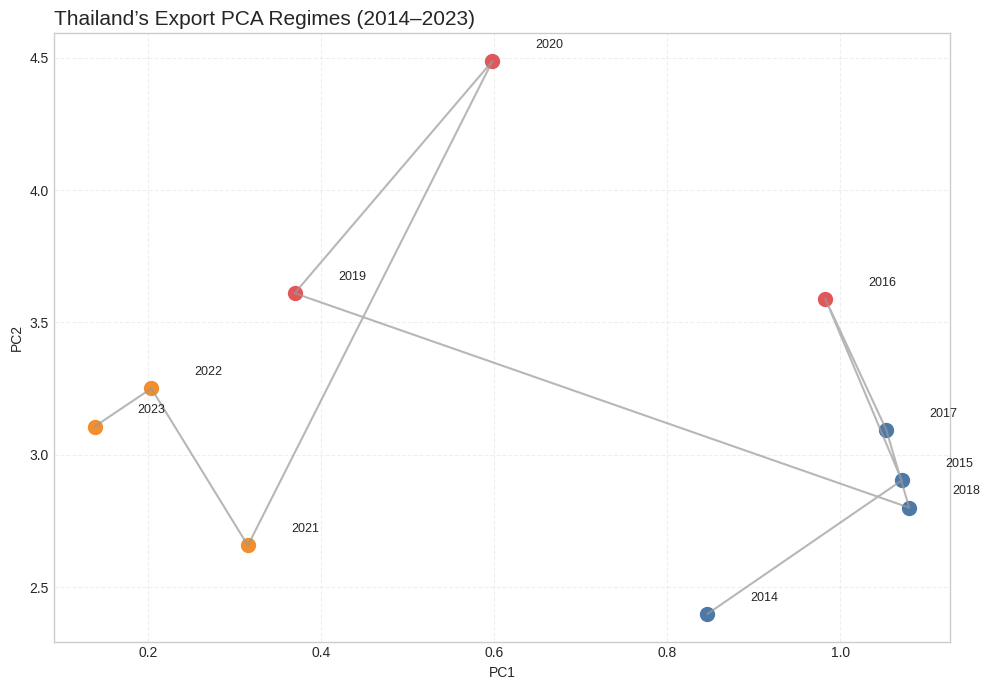

In [34]:
import matplotlib.pyplot as plt

colors = {0:"#E15759", 1:"#4E79A7", 2:"#F28E2B"}  # แยกสีแต่ละ regime

plt.figure(figsize=(10,7))

# Plot line
plt.plot(tha_traj["PC1"], tha_traj["PC2"],
         color="#999999", linewidth=1.5, alpha=0.7)

# Plot points by regime
for i, row in tha_traj.iterrows():
    plt.scatter(row["PC1"], row["PC2"],
                color=colors[row["cluster_tha"]],
                s=100)
    plt.text(row["PC1"]+0.05, row["PC2"]+0.05,
             row["year"], fontsize=9)

plt.title("Thailand’s Export PCA Regimes (2014–2023)", fontsize=15, loc="left")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

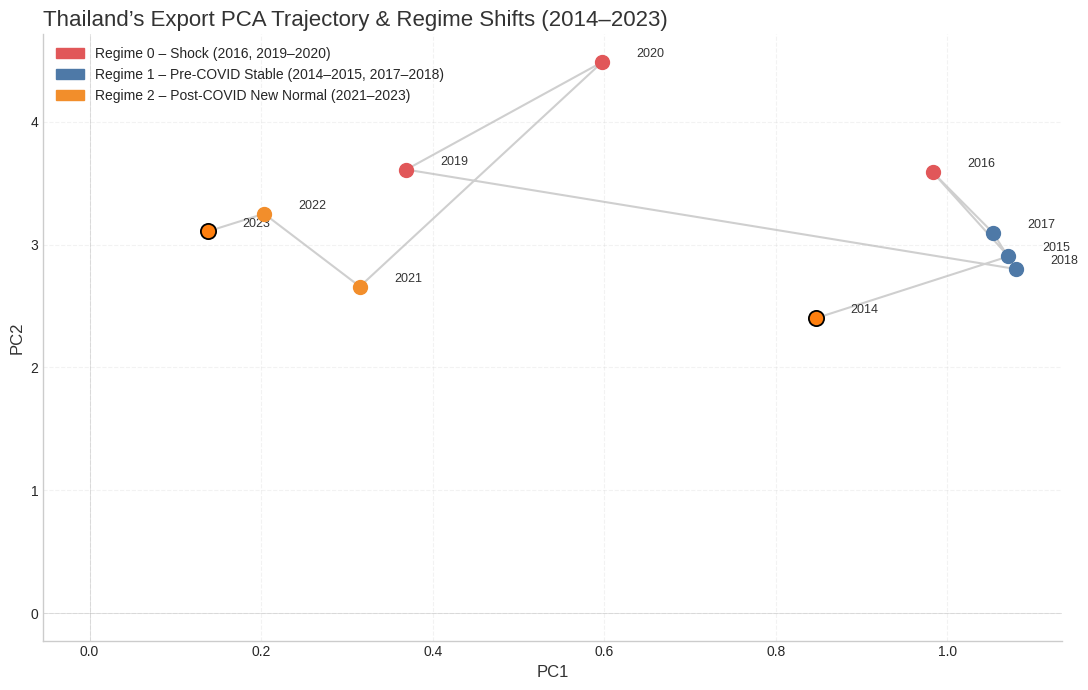

In [41]:
import matplotlib.pyplot as plt

# ====== SWD COLOR PALETTE ======
swd_blue = "#1f77b4"
swd_orange = "#ff7f0e"
text_color = "#333333"

# ====== Cluster-specific colors ======
cluster_colors = {
    0: "#E15759",   # Shock cluster
    1: "#4E79A7",   # Stable pre-COVID cluster
    2: "#F28E2B"    # Post-COVID new-normal cluster
}

plt.figure(figsize=(11, 7))

# ====== Plot the main line (grey for baseline) ======
plt.plot(
    tha_traj["PC1"],
    tha_traj["PC2"],
    color="#bbbbbb",
    linewidth=1.5,
    alpha=0.7
)

# ====== Plot points with cluster colors ======
for i, row in tha_traj.iterrows():
    c = cluster_colors[row["cluster_tha"]]
    plt.scatter(row["PC1"], row["PC2"], color=c, s=100, zorder=5)

# ====== Highlight start/end ======
plt.scatter(
    tha_traj["PC1"].iloc[0],
    tha_traj["PC2"].iloc[0],
    color=swd_orange,
    s=120,
    edgecolor="black",
    linewidth=1.3,
    zorder=6,
    label="2014 start"
)

plt.scatter(
    tha_traj["PC1"].iloc[-1],
    tha_traj["PC2"].iloc[-1],
    color=swd_orange,
    s=120,
    edgecolor="black",
    linewidth=1.3,
    zorder=6,
    label="2023 latest"
)

# ====== Year Labels ======
dx, dy = 0.04, 0.04
for _, row in tha_traj.iterrows():
    plt.text(
        row["PC1"] + dx,
        row["PC2"] + dy,
        str(row["year"]),
        fontsize=9,
        color=text_color
    )

# ====== Axes cleanup ======
plt.axhline(0, color="grey", linewidth=0.5, alpha=0.3)
plt.axvline(0, color="grey", linewidth=0.5, alpha=0.3)

plt.grid(True, linestyle="--", alpha=0.25)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# ====== Title & labels ======
plt.title(
    "Thailand’s Export PCA Trajectory & Regime Shifts (2014–2023)",
    fontsize=16, loc="left", color=text_color
)

plt.xlabel("PC1", fontsize=12, color=text_color)
plt.ylabel("PC2", fontsize=12, color=text_color)

# ====== Cluster Legend ======
import matplotlib.patches as mpatches
patches = [
    mpatches.Patch(color=cluster_colors[0], label="Regime 0 – Shock (2016, 2019–2020)"),
    mpatches.Patch(color=cluster_colors[1], label="Regime 1 – Pre-COVID Stable (2014–2015, 2017–2018)"),
    mpatches.Patch(color=cluster_colors[2], label="Regime 2 – Post-COVID New Normal (2021–2023)")
]

plt.legend(handles=patches, frameon=False, loc="upper left")

plt.tight_layout()
plt.show()

In [42]:
tha_traj[["year", "PC1", "PC2", "cluster", "cluster_tha"]]

,year,PC1,PC2,cluster,cluster_tha
0,2014,0.846472,2.399717,2,1
1,2015,1.071193,2.903951,2,1
2,2016,0.982795,3.589361,2,0
3,2017,1.053307,3.094600,2,1
4,2018,1.079823,2.800846,2,1
5,2019,0.369179,3.610470,2,0
6,2020,0.597922,4.487165,2,0
7,2021,0.315039,2.658189,2,2
8,2022,0.203429,3.251029,2,2
9,2023,0.137734,3.106821,2,2


In [36]:
# Block 5.5: นับจำนวนประเทศในแต่ละคลัสเตอร์ต่อปี

cluster_year_counts = (
    pca_panel_df_reset
    .groupby(["year", "cluster"])["country"]
    .nunique()
    .unstack("cluster")
    .fillna(0)
    .astype(int)
)

cluster_year_counts

cluster,0,1,2
year,,,
2014,3,1,1
2015,3,1,1
2016,3,1,1
2017,3,1,1
2018,3,1,1
2019,3,1,1
2020,3,1,1
2021,3,1,1
2022,3,1,1


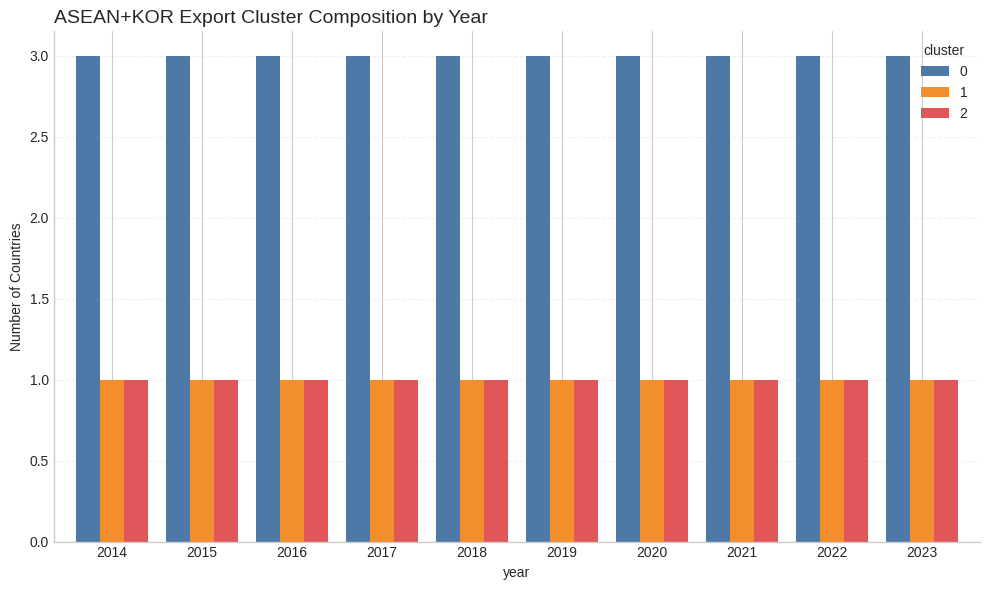

In [43]:
colors = ["#4E79A7", "#F28E2B", "#E15759"]  # cluster 0,1,2

cluster_year_counts.plot(
    kind="bar",
    figsize=(10, 6),
    width=0.8,
    color=colors
)

plt.title(
    "ASEAN+KOR Export Cluster Composition by Year",
    loc="left",
    fontsize=14
)
plt.ylabel("Number of Countries")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

In [38]:
# Block 5.6: ผูก INT share เข้ากับ cluster เพื่อดู profile แต่ละคลัสเตอร์

# ดึง INT share จาก panel_pivot
int_share_panel = panel_pivot[["INT"]].reset_index()   # country, year, INT

# join กับผล PCA/cluster
cluster_profile_df = int_share_panel.merge(
    pca_panel_df_reset[["country", "year", "cluster"]],
    on=["country", "year"],
    how="left"
)

cluster_int_summary = (
    cluster_profile_df
    .groupby(["year", "cluster"])["INT"]
    .mean()
    .unstack("cluster")
    .round(2)
)

cluster_int_summary

cluster,0,1,2
year,,,
2014,69.15,55.99,45.79
2015,68.47,57.52,44.67
2016,67.07,59.56,44.63
2017,67.26,61.42,46.18
2018,68.02,65.54,46.49
2019,67.39,65.29,45.51
2020,68.33,67.85,43.39
2021,69.98,68.55,46.84
2022,72.58,63.73,45.59


In [39]:
# Block 5.6: ผูก INT share เข้ากับ cluster เพื่อดู profile แต่ละคลัสเตอร์

# ดึง INT share จาก panel_pivot
int_share_panel = panel_pivot[["INT"]].reset_index()   # country, year, INT

# join กับผล PCA/cluster
cluster_profile_df = int_share_panel.merge(
    pca_panel_df_reset[["country", "year", "cluster"]],
    on=["country", "year"],
    how="left"
)

cluster_int_summary = (
    cluster_profile_df
    .groupby(["year", "cluster"])["INT"]
    .mean()
    .unstack("cluster")
    .round(2)
)

cluster_int_summary

cluster,0,1,2
year,,,
2014,69.15,55.99,45.79
2015,68.47,57.52,44.67
2016,67.07,59.56,44.63
2017,67.26,61.42,46.18
2018,68.02,65.54,46.49
2019,67.39,65.29,45.51
2020,68.33,67.85,43.39
2021,69.98,68.55,46.84
2022,72.58,63.73,45.59


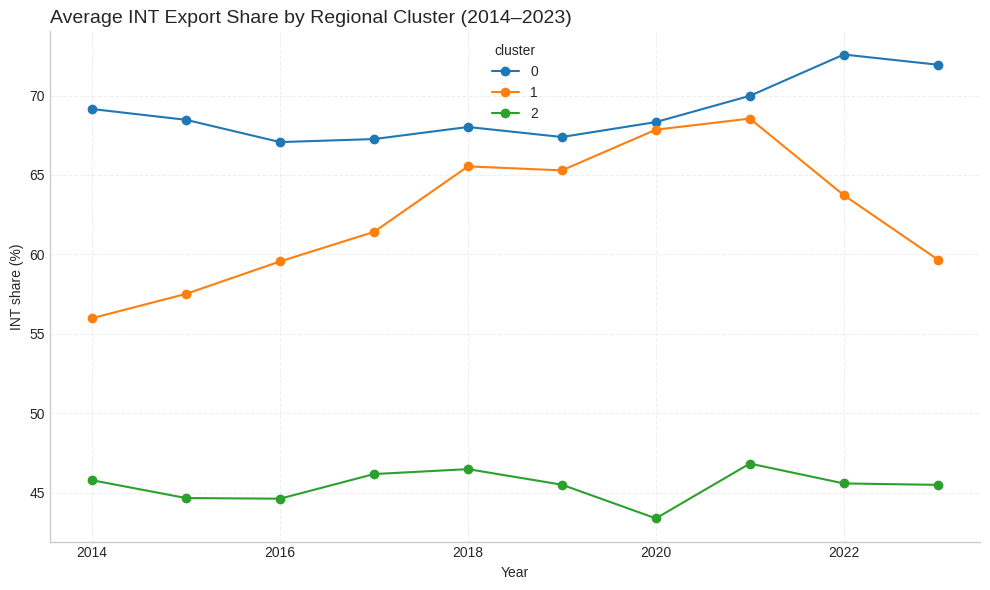

In [44]:
ax = cluster_int_summary.plot(
    kind="line",
    marker="o",
    figsize=(10, 6)
)

ax.set_title(
    "Average INT Export Share by Regional Cluster (2014–2023)",
    loc="left",
    fontsize=14
)
ax.set_ylabel("INT share (%)")
ax.set_xlabel("Year")

ax.grid(True, linestyle="--", alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()